# Federated Learning Implementation with tensorflow



In [1]:
# """
# Adult Dataset Salary Prediction 
# This is part of a study to investigate Differetinal privacy in Machine learning, Naturally we wish to compare it with federated learning.



# Refrences:

# [1] Federated Learning with Non-IID Data, Yue Zhao et al, arXiv: 1806.00582v1, 2 Jun 2018
# [2] Communication-Efficient Learning of Deep Networks from Decentralized Data, H. Brendan McMahan et al, arXiv:1602.05629v3 [cs.LG] 28 Feb 2017

# """

In [2]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
from sklearn.metrics import precision_score,recall_score, accuracy_score,confusion_matrix,f1_score
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History

import pandas as pd



C:\Users\riash\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\riash\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
### Train/Test Data seperation

file_out = pd.read_csv('Data/adult_processed.csv')
cols = []
for i in list(file_out.columns):
    if  i != 'income':
        cols.append(i)

feature_set1 = pd.read_csv('Data/train.csv')
feature_set2 = pd.read_csv('Data/test.csv')

x = feature_set1[cols].copy().values
y = feature_set1[['income']].copy().values
        
sc = StandardScaler()
X_train = sc.fit_transform(x)
y_train = y

x2 = feature_set2[cols].copy().values
y2 = feature_set2[['income']].copy().values
        
X_test = sc.transform(x2)
y_test = y2


X_test.shape, y_test.shape 

((9768, 94), (9768, 1))

In [4]:
# Train/Test data based on  gender: 4 sets

# train

female_features =  feature_set1[feature_set1['gender_Female']==1]
x_female = female_features[cols].copy().values
y_female = female_features[['income']].copy().values

X_train_female = sc.fit_transform(x_female)
y_train_female = y_female

male_features = feature_set1[feature_set1['gender_Male']==1] 
x_male = male_features[cols].copy().values
y_male = male_features[['income']].copy().values

X_train_male = sc.fit_transform(x_male)
y_train_male = y_male

# test

female_features2 =  feature_set2[feature_set2['gender_Female']==1]
x_female2 = female_features2[cols].copy().values
y_female2 = female_features2[['income']].copy().values

X_test_female = sc.fit_transform(x_female2)
y_test_female = y_female2 

male_features2 = feature_set2[feature_set2['gender_Male']==1] 
x_male2 = male_features2[cols].copy().values
y_male2 = male_features2[['income']].copy().values

X_test_male = sc.fit_transform(x_male2)
y_test_male = y_male2


# checks
X_train.shape, X_train_female.shape, X_train_male.shape
# X_test.shape, X_test_female.shape, X_test_male.shape
# y_train.shape, y_train_female.shape, y_train_male.shape

((39073, 94), (12919, 94), (26154, 94))

In [5]:

def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
#     client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

#     iid
#     #randomize the data
#     data = list(zip(image_list, label_list))
#     random.shuffle(data)
    
   
    
#     non-iid //////////////////////////////////////
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

# LOGIC:
#    image_list length-->total data items
#    taking 50 images in each shard--> num_shards = image_list/41 gives 953 shards
#    num_shard = num_shards + 1 if(image_list%50 >0) 

    num_shards, num_imgs = 953, 41
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_clients)}
#     dict_users = [i for i in range(num_clients)]
#     idxs = np.arange(num_shards*num_imgs)
#     labels = dataset.train_labels.numpy()

    max_y = np.argmax(label_list, axis=-1)
#     image_list = np.argmax(image_list, axis=-1)
#     print(idxs.shape, label_list.shape)
    
#     idxs_labels = np.vstack((idxs, max_y))
#     idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
#     idxs = idxs_labels[0, :]

    min_shard = 1
    max_shard = 60  #953/15 = 63.53
    
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_clients)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)


    if sum(random_shard_size) > num_shards:

        for i in range(num_clients):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_clients):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)

    else:

        for i in range(num_clients):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[k]) == 0):
                    dict_users[k] = data[ind1: ind2]
                else:
                    dict_users[k] = np.concatenate(
                    (dict_users[k],data[ind1: ind2]),
                    axis=0)
                
    return dict_users

#   ////////////////////////////////////////////////////  
    #shard data and place at each client
#     size = len(data)//num_clients
#     shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

#     #number of clients must equal number of shards
#     assert(len(shards) == len(client_names))

#     print(len(image_list))
#     for i in range(len(client_names)):
#         print(client_names[i], len(shards[i]))
              
#     return {client_names[i] : shards[i] for i in range(len(client_names))} 


clients = create_clients(X_train, y_train, num_clients=15, initial='client')
# print(clients)

for i in range(len(clients.keys())):
        print(i, len(clients[i]))

print(type(clients))

0 2296
1 82
2 1066
3 3362
4 5453
5 3239
6 1435
7 5330
8 2009
9 2870
10 2501
11 4961
12 1148
13 574
14 2747
<class 'dict'>


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [6]:
# gender split

dict_users = {i: np.array([]) for i in range(5)}
# max_y = np.argmax(y_train, axis=-1)
# sorted_zip = sorted(zip(max_y, y_train, X_train), key=lambda x: x[0])
# data_out = [(x,y) for _,y,x in sorted_zip]
data_out = []

def create_hetero_clients( image_list, label_list, start_client = 0, num_clients=10, initial='clients'):
    
#     non-iid //////////////////////////////////////
    selected_inds = []

    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]
    
    data_out = data
#     print("data", data[0], "do: ", data_out[0])
    
    num_shards, num_imgs = int(len(image_list)/30), 30
    idx_shard = [i for i in range(num_shards)]
#     dict_users = {i: np.array([]) for i in range(num_clients)}

    min_shard = 1
    max_shard = 60  #953/15 = 63.53
    
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=(num_clients-start_client))
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)


    if sum(random_shard_size) > num_shards:
        
        for i in range(start_client, num_clients):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(start_client, num_clients):
            if len(idx_shard) == 0:
                continue
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

    else:

        for i in range(start_client, num_clients):
#             print(random_shard_size)
            shard_size = random_shard_size[i-start_client]
#             shard_size = random_shard_size[int(i/len(random_shard_size)) - 1]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[i]) == 0):
                    dict_users[i] = data[ind1: ind2]
                else:
                    dict_users[i] = np.concatenate(
                    (dict_users[i],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                ind1 = rand*num_imgs
                ind2 = (rand+1)*num_imgs
                if(len(dict_users[k]) == 0):
                    dict_users[k] = data[ind1: ind2]
                else:
                    dict_users[k] = np.concatenate(
                    (dict_users[k],data[ind1: ind2]),
                    axis=0)
                selected_inds.extend([[ind1, ind2]])
# # ////////////
#         for i in range(start_client, num_clients):
#             # First assign each client 1 shard to ensure every client has
#             # atleast one shard of data
#             rand_set = set(np.random.choice(idx_shard, 1, replace=False))
#             idx_shard = list(set(idx_shard) - rand_set)
#             for rand in rand_set:
#                 ind1 = rand*num_imgs
#                 ind2 = (rand+1)*num_imgs
#                 if(len(dict_users[i]) == 0):
#                     dict_users[i] = data[ind1: ind2]
#                 else:
#                     dict_users[i] = np.concatenate(
#                     (dict_users[i],data[ind1: ind2]),
#                     axis=0)
#                 selected_inds.extend([[ind1, ind2]])
                    

#         random_shard_size = random_shard_size-1

#         # Next, randomly assign the remaining shards
#         for i in range(start_client, num_clients):
#             if len(idx_shard) == 0 or len(random_shard_size)<=start_client  or len(random_shard_size)>=(num_clients-1) :
#                 continue
#             if(i<len(random_shard_size)):
#                 shard_size = random_shard_size[i]
#             if shard_size > len(idx_shard):
#                 shard_size = len(idx_shard)
#             rand_set = set(np.random.choice(idx_shard, shard_size,
#                                             replace=False))
#             idx_shard = list(set(idx_shard) - rand_set)
#             for rand in rand_set:
#                 ind1 = rand*num_imgs
#                 ind2 = (rand+1)*num_imgs
#                 if(len(dict_users[i]) == 0):
#                     dict_users[i] = data[ind1: ind2]
#                 else:
#                     dict_users[i] = np.concatenate(
#                     (dict_users[i],data[ind1: ind2]),
#                     axis=0)
#                 selected_inds.extend([[ind1, ind2]])

#     else:

#         for i in range(start_client, num_clients):
#             if len(random_shard_size)<=start_client or len(random_shard_size)>=(num_clients-1):
#                 continue
#             if(i<len(random_shard_size)):
#                 shard_size = random_shard_size[i]
#                 rand_set = set(np.random.choice(idx_shard, shard_size,
#                                             replace=False))
#             idx_shard = list(set(idx_shard) - rand_set)
#             for rand in rand_set:
#                 ind1 = rand*num_imgs
#                 ind2 = (rand+1)*num_imgs
# #                 print(len(dict_users[i]))
#                 if(len(dict_users[i]) == 0):
#                     dict_users[i] = data[ind1: ind2]
#                 else:
#                     dict_users[i] = np.concatenate(
#                     (dict_users[i],data[ind1: ind2]),
#                     axis=0)
#                 selected_inds.extend([[ind1, ind2]])

#         if len(idx_shard) > 0:
#             # Add the leftover shards to the client with minimum images:
#             shard_size = len(idx_shard)
#             # Add the remaining shard to the client with lowest data
#             k = min(dict_users, key=lambda x: len(dict_users.get(x)))
#             rand_set = set(np.random.choice(idx_shard, shard_size,
#                                             replace=False))
#             idx_shard = list(set(idx_shard) - rand_set)
#             for rand in rand_set:
#                 ind1 = rand*num_imgs
#                 ind2 = (rand+1)*num_imgs
#                 if(len(dict_users[k]) == 0):
#                     dict_users[k] = data[ind1: ind2]
#                 else:
#                     dict_users[k] = np.concatenate(
#                     (dict_users[k],data[ind1: ind2]),
#                     axis=0)
#                 selected_inds.extend([[ind1, ind2]])
                
                
    return dict_users, selected_inds, data_out

#   ////////////////////////////////////////////////////  
    #shard data and place at each client
#     size = len(data)//num_clients
#     shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

#     #number of clients must equal number of shards
#     assert(len(shards) == len(client_names))

#     print(len(image_list))
#     for i in range(len(client_names)):
#         print(client_names[i], len(shards[i]))
              
#     return {client_names[i] : shards[i] for i in range(len(client_names))} 

# 1 all male
clients, inds, data_out1 = create_hetero_clients(X_train_male[:5230], y_train_male[:5230], start_client = 0, num_clients=1, initial='client') 
# 1 all female
clients2, inds2, data_out2 = create_hetero_clients(X_train_female[:2584], y_train_female[:2584], start_client = 1, num_clients=2, initial='client')
clients = {**clients, **clients2}


# max_y = np.argmax(y_train_male, axis=-1)
# sorted_zip = sorted(zip(max_y, y_train_male, X_train_male), key=lambda x: x[0])
# data = [(x,y) for _,y,x in sorted_zip]


used_x = []
used_y = []
used_data = []
# print("data_out", data_out[0])
# print("inds", inds)

for i,j in list(inds):
    for x in range(i,j):
        used_data.insert(len(used_data)-1,(data_out1[x]))  
# print("used_data" ,used_data[0])
# print(data_out[inds[0][0]])
    
# for i,j in list(inds):
#     used_x = np.append(used_x, X_train_male[i:j])
#     used_y = np.append(used_y, y_train_male[i:j])
    
for x in used_data:
#     print(x[1])
    used_x.insert(len(used_x)-1,x[0])
    used_y.insert(len(used_y)-1,x[1])  
#     used_x = np.append(used_x,x[0])
#     used_y = np.append(used_y,x[1])

used_data.clear()
# for i,j in list(inds2):
#     used_x = np.append(used_x, X_train_female[i:j])
#     used_y = np.append(used_y, y_train_female[i:j])
    
for i,j in list(inds2):
    for x in range(i,j):
        used_data.insert(len(used_data)-1,(data_out2[x]))  
        
for x in used_data:
    used_x.insert(len(used_x)-1,x[0])
    used_y.insert(len(used_y)-1,x[1])  
    
# print(np.array(used_x).shape)    

# 3 mix
X_train_mix = np.setdiff1d(X_train, np.array(used_x))#53834, 64278
y_train_mix = np.setdiff1d(y_train, np.array(used_y))

print(X_train_mix.shape, X_train.shape)
print(y_train_mix.shape, y_train.shape)

clients3, inds3 , data_out= create_hetero_clients(X_train, y_train, start_client = 2, num_clients=5, initial='client')
clients = {**clients, **clients3}

# print(clients)

for i in range(len(clients.keys())):
        print(i, len(clients[i]))



(64278,) (39073, 94)
(0,) (39073, 1)
0 5220
1 2580
2 13020
3 13020
4 13020


In [19]:
def get_hetero_clients():
    # 1 all male
    clients, inds, data_out1 = create_hetero_clients(X_train_male[:5230], y_train_male[:5230], start_client = 0, num_clients=1, initial='client') 
    # 1 all female
    clients2, inds2, data_out2 = create_hetero_clients(X_train_female[:2584], y_train_female[:2584], start_client = 1, num_clients=2, initial='client')
    clients = {**clients, **clients2}


    # max_y = np.argmax(y_train_male, axis=-1)
    # sorted_zip = sorted(zip(max_y, y_train_male, X_train_male), key=lambda x: x[0])
    # data = [(x,y) for _,y,x in sorted_zip]


    used_x = []
    used_y = []
    used_data = []
    # print("data_out", data_out[0])
    # print("inds", inds)

    for i,j in list(inds):
        for x in range(i,j):
            used_data.insert(len(used_data)-1,(data_out1[x]))  
    # print("used_data" ,used_data[0])
    # print(data_out[inds[0][0]])

    # for i,j in list(inds):
    #     used_x = np.append(used_x, X_train_male[i:j])
    #     used_y = np.append(used_y, y_train_male[i:j])

    for x in used_data:
    #     print(x[1])
        used_x.insert(len(used_x)-1,x[0])
        used_y.insert(len(used_y)-1,x[1])  
    #     used_x = np.append(used_x,x[0])
    #     used_y = np.append(used_y,x[1])

    used_data.clear()
    # for i,j in list(inds2):
    #     used_x = np.append(used_x, X_train_female[i:j])
    #     used_y = np.append(used_y, y_train_female[i:j])

    for i,j in list(inds2):
        for x in range(i,j):
            used_data.insert(len(used_data)-1,(data_out2[x]))  

    for x in used_data:
        used_x.insert(len(used_x)-1,x[0])
        used_y.insert(len(used_y)-1,x[1])  

    # print(np.array(used_x).shape)    

    # 3 mix
    X_train_mix = np.setdiff1d(X_train, np.array(used_x))#53834, 64278
    y_train_mix = np.setdiff1d(y_train, np.array(used_y))

    print(X_train_mix.shape, X_train.shape)
    print(y_train_mix.shape, y_train.shape)

    clients3, inds3 , data_out= create_hetero_clients(X_train, y_train, start_client = 2, num_clients=5, initial='client')
    clients = {**clients, **clients3}
    
    return clients


In [7]:
# take bs = 128 for 5 clients and 10 rounds
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    
    return dataset.shuffle(len(label)).batch(bs)

In [27]:

#process and batch the training data for each client
def batch_clients(clients):
    clients_batched = dict()
    for (client_name, data) in clients.items():
    #     print(data[0])
        clients_batched[client_name] = batch_data(data)

    #process and batch the test set  
    test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))
#     test_batched
    return clients_batched, test_batched


In [9]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes=2 , learning_rate = 0.001, metric = "accuracy"):

        model = Sequential()
        
        model.add(Dense(128, input_shape = (shape,)))
#         model.add(Dense(128, Activation("relu")))
#         model.add(Dense(64, Activation("relu")))
#         model.add(Dense(32, Activation("relu")))
#         model.add(Dense(1))
        
        model.add(Dense(128, Activation("tanh")))
        model.add(Dense(64, Activation("tanh")))
        model.add(Dense(32, Activation("tanh")))
        model.add(Dense(1,Activation('sigmoid')))
        


        return model

In [30]:
lr = 0.005
comms_round = 3
loss=tf.keras.losses.BinaryCrossentropy(from_logits = False)

metrics = ['binary_accuracy']

optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.5
               )     



In [11]:


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
#     print(len(scaled_weight_list))
    for grad_list_tuple in zip(*scaled_weight_list):
#         print(len(grad_list_tuple))
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    
#     cce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
#     cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    logits = model.predict(X_test)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    acc = score[1] ; loss = score[0]
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))

    return acc, loss

In [29]:

#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(X_train.shape[1] ,classes=2)
global_model.compile(optimizer=optimizer, loss=loss, metrics=metrics) 
clients_batched, test_batched = batch_clients(clients)
client_names= list(clients_batched.keys())
print(client_names, "asugdefbh")
# print(clients_batched)

client_loss = {i: np.array([]) for i in range(len(list(clients_batched.keys())))}
client_frequency = {i: np.array([]) for i in range(len(list(clients_batched.keys())))}

        
#commence global training loop
for comm_round in range(comms_round):
            
#     clients = create_clients(X_train, y_train, num_clients=15, initial='client')
    clients = get_hetero_clients()
    clients_batched, test_batched = batch_clients(clients)
        
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    print(client_names)
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(X_train.shape[1],classes=2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        history = local_model.fit(clients_batched[client], epochs=1, verbose=1)
        
#         get client acc, loss
#         print(client)
        if(len(client_loss[client])== 0):
            client_loss[client] = [history.history['loss'][0]]
            client_frequency[client] = [len(clients_batched[client])]
        
        else:
            client_loss[client] = np.append(client_loss[client], (history.history['loss'][0]))
            client_frequency[client] = np.append(client_frequency[client], len(clients_batched[client]))
        
        print("client", client, "loss -->" ,client_loss[client], "freq->", client_frequency[client])
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

#     test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)



[0, 1, 2, 3, 4] asugdefbh
(64278,) (39073, 94)
(0,) (39073, 1)
[0, 1, 2, 3, 4]
653/653 [==============================] - 1s 1ms/step - loss: 0.6156 - binary_accuracy: 0.6546
client 0 loss --> [0.6156252026557922] freq-> [653]
1507/1507 [==============================] - 2s 1ms/step - loss: 0.5165 - binary_accuracy: 0.7442
client 2 loss --> [0.5165041089057922] freq-> [1507]
1718/1718 [==============================] - 2s 1ms/step - loss: 0.5190 - binary_accuracy: 0.7405
client 3 loss --> [0.5190188884735107] freq-> [1718]
324/324 [==============================] - 0s 1ms/step - loss: 0.6478 - binary_accuracy: 0.6151
client 1 loss --> [0.6478134393692017] freq-> [324]
1658/1658 [==============================] - 3s 2ms/step - loss: 0.5410 - binary_accuracy: 0.7239
client 4 loss --> [0.5410465002059937] freq-> [1658]
comm_round: 0 | global_acc: 80.498% | global_loss: 0.4465489089488983
(64278,) (39073, 94)
(0,) (39073, 1)
[0, 1, 2, 3, 4]
1777/1777 [==============================] - 3s 2

client_ 0  loss:  [0.6156252  0.48066768 0.44973335] freq:  [653 735 816]


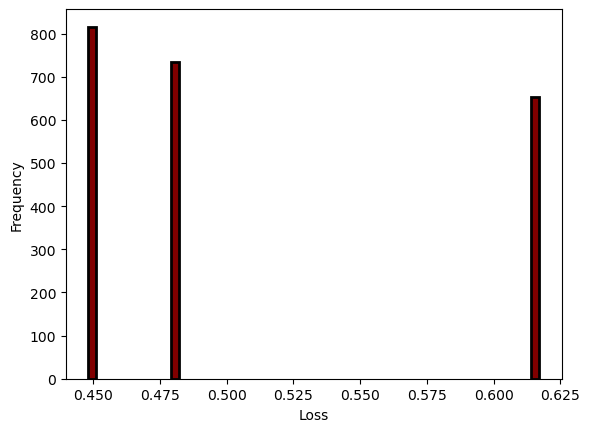

client_ 1  loss:  [0.64781344 0.38447961 0.32909143] freq:  [324 364 405]


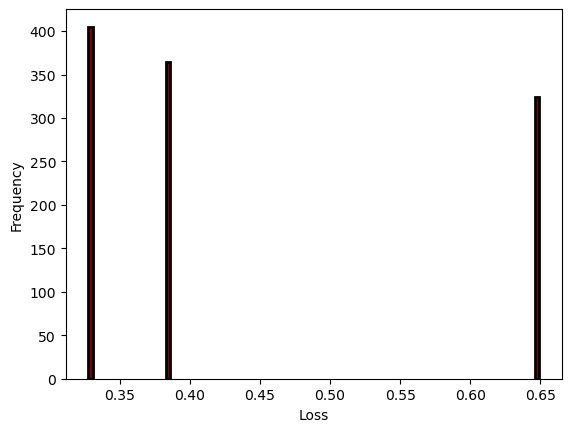

client_ 2  loss:  [0.51650411 0.41087717 0.38291788] freq:  [1507 1777 2294]


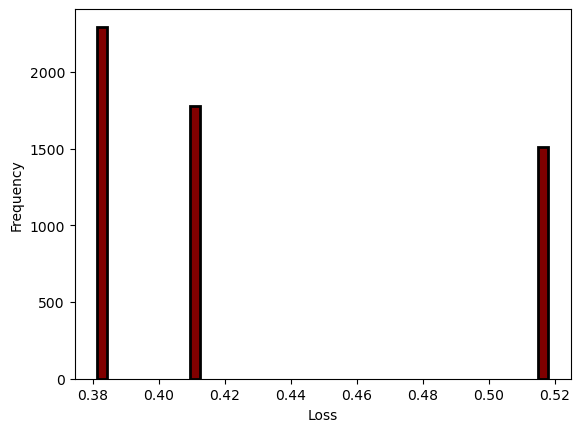

client_ 3  loss:  [0.51901889 0.4161503  0.38301086] freq:  [1718 1748 1823]


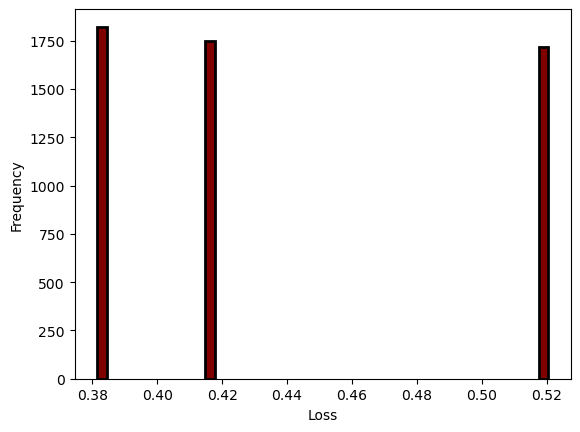

client_ 4  loss:  [0.5410465  0.41257161 0.38473815] freq:  [1658 1968 1987]


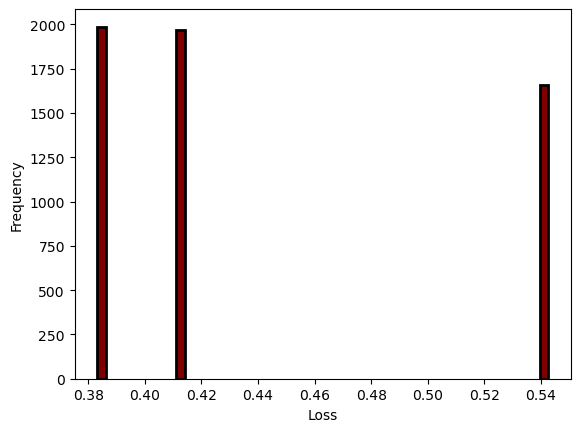

In [31]:
import matplotlib.pyplot as plt
for i in list(client_loss.keys()):
#     plt.hist2d(client_loss[i], client_frequency[i])
#     plt.hist(client_loss[i])
    print("client_",i, " loss: ", client_loss[i],"freq: ", client_frequency[i])
    plt.bar(client_loss[i], client_frequency[i],   width=0.003, linewidth = 2, color = 'maroon', edgecolor = "black")  
    plt.ylabel("Frequency")
    plt.xlabel("Loss")
    plt.show()

In [32]:
score = global_model.evaluate(X_test, y_test, verbose=0)
score

[0.3802128732204437, 0.8311834335327148]

In [33]:
nn_preds = global_model.predict(X_test)
nn_preds = (nn_preds > 0.5)

nn_precision =precision_score(y_test, nn_preds)
nn_recall = recall_score(y_test, nn_preds)
nn_accuracy = accuracy_score(y_test, nn_preds)
nn_f1 = f1_score(y_test, nn_preds)


print("Precision = {}".format(nn_precision))
print("Recall = {}".format(nn_recall))
print("Accuracy = {}".format(nn_accuracy))
print("f1 = {}".format(nn_f1))


Precision = 0.6855643044619423
Recall = 0.5543293718166383
Accuracy = 0.8311834561834562
f1 = 0.6130016428068529


In [34]:
arr = nn_preds > 0.5

unique, counts = np.unique(arr, return_counts=True)

np.asarray((unique, counts)).T

array([[   0, 7863],
       [   1, 1905]], dtype=int64)

In [ ]:
# pdf for client losses
# x-loss
# y- frequency
# each client has one pdf for all rounds
# using histogram


# drop client
# non iid
# fedavg


# gender dist